In [126]:
import numpy as np
import matplotlib.pyplot as plt

# add project root folder to path to allow import local modules
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
# import local modules
from helpers import compute_ridge_loss
from helpers import *
from implementations import *
from preprocessing import *

In [80]:
np.random.seed(2020)

## Load Datasets


In [2]:
p = Preprocessing(load_csv('../dataset/trainset.csv'))
y_train , x_train= p.preprocess()
p = Preprocessing(load_csv('../dataset/testset.csv'))
y_test, x_test = p.preprocess()

In [3]:
print(x_train.shape)
print(x_test.shape)

(225000, 31)
(25000, 31)


## Prediction with decision boundary

In [19]:
def predict(weight, x_test, boundary = 0.5):
    """
    # Gives predictions given weight and datapoints 
    
    :param weight: vector weight
    :type weight: 1D array
    
    :param x_test: extended feature matrix
    :type x_test: 2D array
    
    :return: label predictions (0 or 1)
    :rtype:  1D numpy array
    
    """
    
    pred = x_test.dot(weight)
    return (pred > boundary)*1
    

## Ridge Regression on dataset

In [46]:
w, loss = ridge_regression(y_train, x_train,0.004)
print(w) # gives an idea about the important columns.. 
print(loss)

[ 3.39876543e-01  2.92215114e-03 -1.25170884e-01 -1.21200506e-01
  3.75508083e-03  1.37591143e-02  4.30769267e-02  3.09171484e-03
  1.34088164e-01 -1.40882957e-02  2.66338549e-02 -8.71212711e-02
  5.88851209e-02  3.77909539e-02  8.54348852e-02  1.65467729e-04
 -3.54879843e-04  1.27488054e-01 -8.40100689e-04  7.48630428e-04
  4.81747423e-02  5.28005644e-04 -2.16649214e-02  1.76743327e-02
 -2.41109249e-02  2.64536026e-04 -1.22418485e-04 -1.83071720e-02
  4.69187461e-04 -2.53235820e-04 -1.67847801e-02]
0.0860017342358788


##  Cross Validation

In [139]:
def build_k_indices(y, k_fold):
    """build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval]
                 for k in range(k_fold)]
    return np.array(k_indices)

def K_Cross_Validation(x, y, K, _lambda):
    #Initialization of all needed arrays
    test_loss = np.zeros(K)
    train_loss = np.zeros(K)
    weights = np.zeros((K,x.shape[1]))
    accuracy = np.zeros(K)
    indices = build_k_indices(y, K)
    
    for i in range(K):
        test_indices = indices[i]
        y_test = y[test_indices]
        y_train = np.delete(y,test_indices)
        x_test = x[test_indices,:]
        x_train = np.delete(x,test_indices,axis=0)

        ### ADAPT METHOD & LOSS
        weights[i], train_loss[i] = ridge_regression(y_train, x_train,_lambda)
        test_loss[i] = compute_ridge_loss(y_test,x_test,weights[i],_lambda)
        
        #Calculate predictions of the model
        predictions = predict(weights[i] , x_test)
        #Calculate accuracy of the model
        accuracy[i] = np.sum(predictions == y_test) / len(y_test)
        
    return accuracy, test_loss, train_loss, np.mean(weights, axis=0)
        

0.5923995181336806


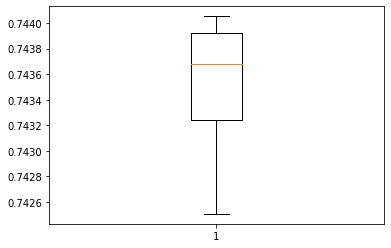

In [140]:
accs,test_loss, train_loss, w = K_Cross_Validation(x_train,y_train,4,0.001)
plt.boxplot(accs)
print(acc.mean())

## Tune Hyperparameters

In [148]:
def Tune_lambda(xt_training, y_training, K, gamma_range):
        
    gammas = np.linspace(0.00000001, gamma_range, 20)
    max_acc = 0
    opt_lambda = 0
    accuracies = []
    train_losses = []
    test_losses = []
    for i, gamma in enumerate(gammas):
       
        accuracy,test,train,w = K_Cross_Validation(xt_training, y_training, K,gamma)
        accuracies.append([gamma,accuracy.mean()])
        train_losses.append([gamma,train.mean()])
        test_losses.append([gamma,test.mean()])
        if (accuracy.mean() > max_acc):
            max_acc = accuracy.mean()
            opt_gamma = gamma
                
    return opt_gamma , max_acc, np.array(accuracies), np.array(train_losses), np.array(test_losses)
opt_lambda, max_acc, acc ,train, test= Tune_lambda(x_train, y_train, 5, 1)

print(f"optimal acc = {max_acc} with lambda= {opt_lambda}")

optimal acc = 0.7437155555555555 with lambda= 1e-08


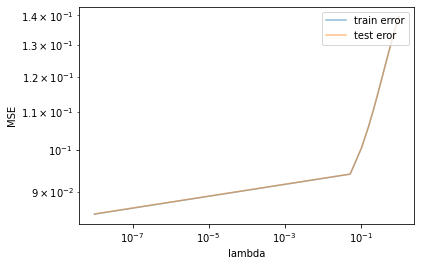

In [175]:

#plt.plot(acc[:,0],acc[:,1], label="accuracy")
plt.plot(train[:,0],train[:,1],alpha=0.5,label="train error")
plt.plot(test[:,0],test[:,1],alpha=0.5, label = "test eror")
plt.yscale("log")
plt.xscale("log")
plt.xlabel("lambda")
plt.ylabel("MSE")
plt.legend(loc="upper right")
plt.show()

model is clearly **UNDERFITTING**, test and train score are exactly the same and increasing

## predictions on test set 

In [158]:
w_opt,loss = ridge_regression(y_train,x_train,opt_lambda)
p = predict(w_opt,x_test)
print((p==y_test).mean())

0.74876


In [163]:
w_opt


array([ 3.42595549e-01,  4.75398658e-03, -1.27152015e-01, -1.31233070e-01,
        1.25109606e-03,  1.27839942e-02,  4.46662143e-02,  3.84240729e-03,
        1.41037948e-01, -1.39759723e-02, -9.87030206e-02, -9.34822816e-02,
        5.88911070e-02,  3.80991283e-02,  1.10926697e-01,  2.15848420e-04,
       -2.91542903e-04,  1.62213617e-01, -8.71809554e-04,  7.34743015e-04,
        5.14280226e-02,  4.94734830e-04, -2.30882397e-02,  2.20593829e-02,
       -2.35776807e-02,  2.80488044e-04, -1.45172563e-04, -1.75590877e-02,
        4.62640959e-04, -2.59382520e-04,  8.52681355e-02])